# 1. Dataset Exploration (EDA)

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import kagglehub


We have a model with three directories, a train directory, a test directory and a val directory. Each directory have two carpets with images, are human chest of people with pneumonia and people without it.

In [3]:
train_path = os.path.join(path, "chest_xray", "train")
val_path = os.path.join(path, "chest_xray", "val")
test_path = os.path.join(path, "chest_xray", "test")

def count_images(folder):
    counts = {}
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        counts[class_name] = len(os.listdir(class_folder))
    return counts

print("Train distribution:", count_images(train_path))
print("Validation distribution:", count_images(val_path))
print("Test distribution:", count_images(test_path))


Train distribution: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation distribution: {'NORMAL': 8, 'PNEUMONIA': 8}
Test distribution: {'NORMAL': 234, 'PNEUMONIA': 390}


Almost all the images have different sizes, meaning we have to organize them in equal sizes.

In [4]:
sizes = set()

for class_name in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(train_path, class_name)
    for img_name in os.listdir(folder)[:50]:
        img = Image.open(os.path.join(folder, img_name))
        sizes.add(img.size)

print("Different image sizes found:", sizes)


Different image sizes found: {(1750, 1314), (1072, 768), (1328, 1368), (1434, 1260), (1518, 1156), (992, 680), (1854, 1572), (1724, 1581), (1384, 1167), (1618, 1279), (1576, 1328), (1458, 1190), (1216, 792), (904, 624), (1688, 1105), (1128, 520), (1450, 1144), (1136, 704), (968, 656), (1612, 1133), (1008, 728), (2164, 1746), (1152, 760), (1466, 1109), (1592, 1312), (1336, 944), (1040, 747), (2148, 1496), (2136, 1650), (1520, 936), (1848, 1448), (1528, 1013), (1048, 888), (1080, 984), (1646, 1124), (1596, 1156), (1244, 863), (2338, 2025), (2010, 1747), (1008, 616), (1372, 1005), (1048, 664), (1426, 1049), (1740, 1453), (1488, 1280), (1553, 1044), (1232, 720), (1600, 1125), (1288, 816), (1156, 1237), (1272, 728), (1810, 1434), (1184, 752), (1488, 1209), (1184, 816), (1554, 1075), (1368, 872), (856, 480), (1506, 833), (1104, 792), (2102, 1974), (1128, 832), (1240, 792), (1736, 1752), (1584, 1328), (1876, 1893), (1048, 716), (912, 480), (1774, 1546), (1422, 1152), (1680, 1557), (502, 307),

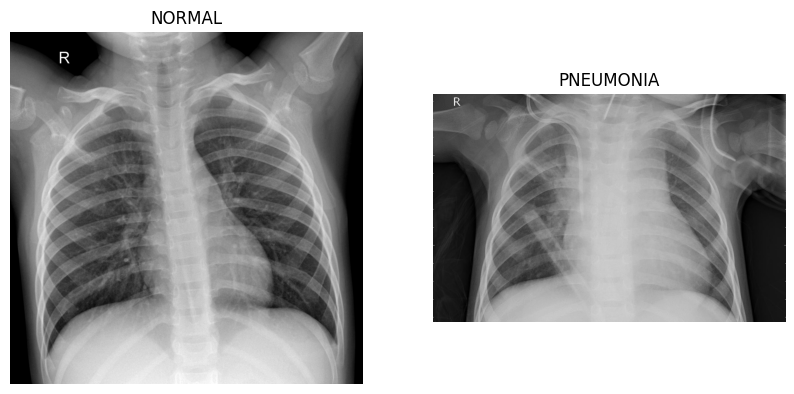

In [5]:
import matplotlib.pyplot as plt
import random

classes = ["NORMAL", "PNEUMONIA"]

plt.figure(figsize=(10,5))

for i, class_name in enumerate(classes):
    folder = os.path.join(train_path, class_name)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)

    img = Image.open(img_path)

    plt.subplot(1,2,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(class_name)
    plt.axis("off")

plt.show()


There are two image modes found, RGB and L, we have to convert it into one for working purposes.

In [6]:
from PIL import Image
import os

modes = set()

for class_name in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(train_path, class_name)
    for img_name in os.listdir(folder)[:50]:
        img = Image.open(os.path.join(folder, img_name))
        modes.add(img.mode)

print("Different image modes found:", modes)


Different image modes found: {'RGB', 'L'}


# 2. Baseline Model (Non-Convolutional)


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


This cell is used for preparing the data, setting it ready for training and validation, with TensorFlow’s ImageDataGenerator. We import libraries used, followed by setting key parameter configurations: image shape (set to 224×224) and batch size (set to 32). These are essential in ensuring all images are resized to a standard shape for entry into a network.

The directory paths used for the training set, validation set, and test set are defined based on their locations. The ImageDataGenerator is defined by incorporating one normalizing step (rescale=1./255), which normalizes pixels in the range [0, 255] to be in the interval [0, 1].

Finally, the flow_from_directory method is used to load the images from the directory , where each subdirectory is used for labeling the classes. Images are resized appropriately, put into batches, and labeled automatically. In this case, the problem is a binary problem with classes NORMAL and PNEUMONIA; hence, class_mode is set to "binary".

We define two generators in our code, one for the training data (train_data) and one for the validation data (val_data). We will use these generators in the upcoming steps for the purpose of training our model.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMG_SIZE = 224
BATCH_SIZE = 32

train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


This cell sets the baseline for a neural network by using a simple "fully connected" architecture without the use of convolutional layers. The neural network architecture starts with a "Flatten" layer that takes the input images of size 224x224x3 and transforms them into vectors.

Two Dense layers with 128 and 64 neurons are used with ReLU activation functions to inject non-linearity and allow the model to learn complex features. The final layer, an output layer, has one neuron with a sigmoid activation function, which is considered appropriate for binary classification problems such as Normal vs Pneumonia.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    Flatten(input_shape=(224,224,3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,276,033 (73.53 MB)

 Trainable params: 19,276,033 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

This cell trains the baseline neural network using the training dataset and validates the model using the validation dataset. The model.fit() function progressively adjusts the model’s weights with regard to the data.

This process is repeated for 5 epochs, indicating the entire dataset is passed through the network 5 times. This means the entire dataset is loaded, predictions are made, and the parameters for the network are adjusted to optimize the error.

The parameter “validation_data” facilitates the evaluation of the performance of the model after the completion of each epoch via unseen data. This helps to understand the capacity of the model to generalize; overfitting may also be recognized.

The training history is stored in the history object, which includes metrics like training loss, validation loss, and accuracy per epoch, allowing for visualization at a later time.

In [25]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9686 - loss: 0.1860 - val_accuracy: 1.0000 - val_loss: 0.2886
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 295ms/step - accuracy: 0.9747 - loss: 0.1650 - val_accuracy: 0.9375 - val_loss: 0.2644
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 296ms/step - accuracy: 0.9797 - loss: 0.1449 - val_accuracy: 0.8750 - val_loss: 0.3029
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.9789 - loss: 0.1366 - val_accuracy: 1.0000 - val_loss: 0.2236
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.9707 - loss: 0.1410 - val_accuracy: 0.7500 - val_loss: 0.5393


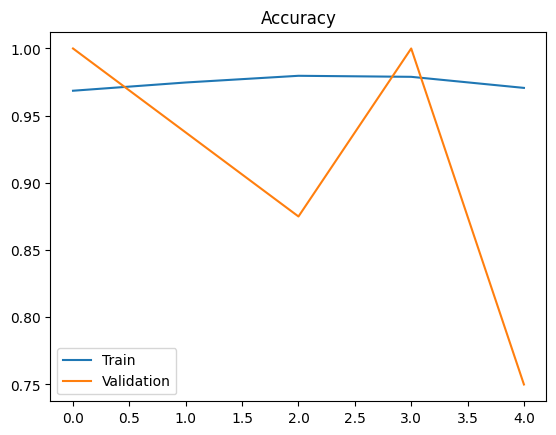

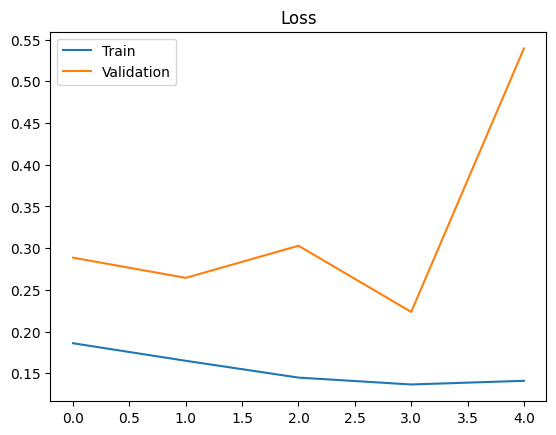

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Train','Validation'])
plt.show()


# 3. Convolutional Architecture Design

This cell defines a CNN specially designed for the image classification task on chest X-ray images. It consists of three convolution blocks with subsequent fully connected layers for classification.

The model initiates with a convolutional layer comprising 32 filters of size 3×3 and ReLU for activation. This enables the network to detect low-level features such as edges and textures. Following each convolutional layer, there is a MaxPooling layer (2×2) that reduces spatial dimensions, decreases computational cost, and provides some translation invariance.

The number of filters increases progressively: 32 → 64 → 128. This allows the network to learn more complex and higher-level features at deeper layers. All convolutional layers use a stride of 1 with implicit "valid" padding. This maintains local feature extraction with gradual reduction in feature map size by pooling.

This includes a flatten operation to convert the output to a one-dimensional vector, and it passes through a fully connected layer of 128 neurons with ReLU activation. A Dropout layer with a value of 0.5 is added to reduce overfitting by randomly disabling the neurons during training.

Finally, the final layer is a single neuron with the sigmoid activation function, which works well on binary classification problems, such as Normal versus Pneumonia.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cnn_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 803ms/step - accuracy: 0.8888 - loss: 0.2975 - val_accuracy: 0.7500 - val_loss: 0.3301
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy: 0.9586 - loss: 0.1170 - val_accuracy: 0.9375 - val_loss: 0.1889
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 774ms/step - accuracy: 0.9664 - loss: 0.0961 - val_accuracy: 0.8125 - val_loss: 0.2634
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 807ms/step - accuracy: 0.9716 - loss: 0.0764 - val_accuracy: 0.8125 - val_loss: 0.2800
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/step - accuracy: 0.9799 - loss: 0.0590 - val_accuracy: 0.8750 - val_loss: 0.2153


This cell loads the test dataset and tests the trained CNN model on the unseen data. Once again, the flow_from_directory function is used to create a data generator. However, this time, the images are read from the test directory, resized to 224 x 224 pixels, and normalized.

In [19]:
test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

cnn_model.evaluate(test_data)


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.7308 - loss: 1.3643


[1.3643059730529785, 0.7307692170143127]

# 4. Controlled Experiments on the Convolutional Layer
## Experiment: Depth (1 vs 2 vs 3 conv layers)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

EPOCHS = 5


### 1 depth

In [22]:
model_depth_1 = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_depth_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_depth_1.summary()

history_depth_1 = model_depth_1.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,845,633 (49.00 MB)

 Trainable params: 12,845,633 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - accuracy: 0.9273 - loss: 0.2951 - val_accuracy: 0.9375 - val_loss: 0.1437
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 314ms/step - accuracy: 0.9751 - loss: 0.0689 - val_accuracy: 0.9375 - val_loss: 0.2300
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9870 - loss: 0.0403 - val_accuracy: 0.7500 - val_loss: 0.2780
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.8750 - val_loss: 0.2156
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.9998 - loss: 0.0044 - val_accuracy: 0.9375 - val_loss: 0.1810


### 2 depth

In [21]:
model_depth_2 = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_depth_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_depth_2.summary()

history_depth_2 = model_depth_2.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,427,745 (24.52 MB)

 Trainable params: 6,427,745 (24.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step - accuracy: 0.9122 - loss: 0.3350 - val_accuracy: 0.8750 - val_loss: 0.1850
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 304ms/step - accuracy: 0.9670 - loss: 0.0947 - val_accuracy: 0.7500 - val_loss: 0.4953
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.9776 - loss: 0.0604 - val_accuracy: 0.7500 - val_loss: 0.3146
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.9850 - loss: 0.0441 - val_accuracy: 1.0000 - val_loss: 0.0405
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.9887 - loss: 0.0352 - val_accuracy: 0.9375 - val_loss: 0.1297


### 3 depth

In [20]:
model_depth_3 = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_depth_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_depth_3.summary()

history_depth_3 = model_depth_3.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,234,977 (12.34 MB)

 Trainable params: 3,234,977 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 324ms/step - accuracy: 0.9308 - loss: 0.1704 - val_accuracy: 0.7500 - val_loss: 0.5897
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 333ms/step - accuracy: 0.9609 - loss: 0.1056 - val_accuracy: 0.8125 - val_loss: 0.2114
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 307ms/step - accuracy: 0.9778 - loss: 0.0633 - val_accuracy: 1.0000 - val_loss: 0.1368
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 306ms/step - accuracy: 0.9812 - loss: 0.0496 - val_accuracy: 0.9375 - val_loss: 0.1183
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 312ms/step - accuracy: 0.9893 - loss: 0.0311 - val_accuracy: 0.8125 - val_loss: 0.3837


In [23]:
print("Depth 1 → Val Acc:", history_depth_1.history['val_accuracy'][-1],
      "Val Loss:", history_depth_1.history['val_loss'][-1])

print("Depth 2 → Val Acc:", history_depth_2.history['val_accuracy'][-1],
      "Val Loss:", history_depth_2.history['val_loss'][-1])

print("Depth 3 → Val Acc:", history_depth_3.history['val_accuracy'][-1],
      "Val Loss:", history_depth_3.history['val_loss'][-1])


Depth 1 → Val Acc: 0.9375 Val Loss: 0.18104860186576843
Depth 2 → Val Acc: 0.9375 Val Loss: 0.129719078540802
Depth 3 → Val Acc: 0.8125 Val Loss: 0.3836890459060669


The experiment shows that increasing the depth of a network is not necessary to ensure better performance. While both one- and two-layer convolutional models have achieved the same value of validation accuracy (93.75%), the two-layer model obtained more confident and stable predictions because of its lower validation loss.

It performed worse, yielding only 81.25% for validation accuracy and significantly higher validation loss. This indicates that the deeper architecture may start overfitting on the training data or that the size of the dataset was too small to train a more complex model.

These results suggest that for this task and dataset, two convolutional layers were deep enough to capture the relevant features necessary for pneumonia classification.

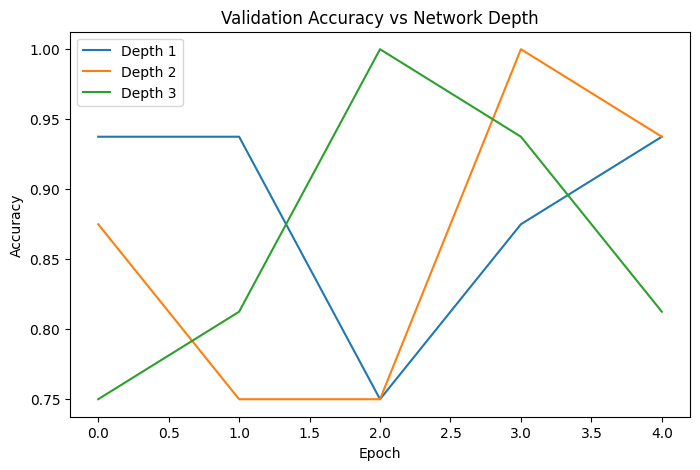

In [24]:
plt.figure(figsize=(8,5))
plt.plot(history_depth_1.history['val_accuracy'], label='Depth 1')
plt.plot(history_depth_2.history['val_accuracy'], label='Depth 2')
plt.plot(history_depth_3.history['val_accuracy'], label='Depth 3')
plt.title("Validation Accuracy vs Network Depth")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Increasing the model complexity with extra convolutional layers is associated with an increase in the computational cost and generally increases the training time. While deeper models have greater representational capacity, they require more data and regularization to avoid overfitting.

One-layer was much simpler, faster to train, but the predictions were a bit less stable than for two-layer. The two-layer model gave the best balance of performance and complexity: it achieved high accuracy with lower loss.

Only additional parameters were added by the three-layer model, while it did not improve performance. This shows again that adding layers is not always desired; model depth must be selected based on the size of the dataset and the complexity of the problem.

# 5. Interpretation and Architectural Reasoning

## Why did convolutional layers outperform (or not) the baseline?

The reason the convolutional layers outperformed the baseline dense network, its for the capacity to read better the images than the baseline.

While the baseline converts the images into one direction vectors, it lose information of the image, making it less effective at detecting patterns for the detection of pneumonia.

Convolutional layer apply filters in different regions on the image, it makes that the CNN learn more features of the images, making it better to detect the patterns

## What inductive bias does convolution introduce?

Introduce an inductive bias towards locality and translation invariance

* Locality: The networks assumes that nearby pixels are more related than distant pixels. This is appropriate for images, where feature are local.
* Translation invariance: If a feature moves in the image, it is still detectable.

## In what type of problems would convolution not be appropriate?

* When there is no relation between the variables.
* The feature positions are independent.
* There is a small input or is already calculated.


# 6. Deployment in Sagemaker


In [ ]:
#